In [1]:
import os

# 设置工作路径
os.chdir('/home/workplace/MVC/SpaAGAC')
from utils.misc import *
from train.train3 import Train,Test
from model.Creat_model import creat_model
from utils.preprocess import *
from utils.utils import *

2025-07-21 09:23:33.196541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-21 09:23:33.329720: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 09:23:33.931875: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:
2025-07-21 09:23:33.931964: W tensorflow/compiler/xla/stream_executor/p

In [2]:
from torch.backends import cudnn
def fix_seed(seed):
    #seed = 2023
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'   

In [3]:
import networkx
import torch
import scipy.sparse as sp
import numpy as np
import os
import random
from munkres import Munkres
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.decomposition import PCA
from torch.utils.data import Dataset
import argparse
import yaml
from torch_geometric.utils.convert import to_networkx
import pynvml

def build_args():
    
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--dataset', type=str, default="acm")
    parser.add_argument('--seed', type=int, default=20)
    parser.add_argument('--cuda', type=bool, default=True)
    parser.add_argument('--n_input', type=int, default=None)
    parser.add_argument('--n_z', type=int, default=None)
    parser.add_argument('--freedom_degree', type=float, default=1.0)
    parser.add_argument('--epoch', type=int, default=None)
    parser.add_argument('--shuffle', type=bool, default=True)
    parser.add_argument('--sigma', type=float, default=None)
    parser.add_argument('--loss_n', type=float, default=None)
    parser.add_argument('--loss_w', type=float, default=None)
    parser.add_argument('--loss_s', type=float, default=None)
    parser.add_argument('--loss_a', type=float, default=None)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--acc', type=float, default=-1)
    parser.add_argument('--f1', type=float, default=-1)
    args = parser.parse_args([])
    return args

In [4]:
def pca(adata, use_reps=None, n_comps=10):
    
    """Dimension reduction with PCA algorithm"""
    
    from sklearn.decomposition import PCA
    from scipy.sparse.csc import csc_matrix
    from scipy.sparse.csr import csr_matrix
    pca = PCA(n_components=n_comps)
    if use_reps is not None:
       feat_pca = pca.fit_transform(adata.obsm[use_reps])
    else: 
       if isinstance(adata.X, csc_matrix) or isinstance(adata.X, csr_matrix):
          feat_pca = pca.fit_transform(adata.X.toarray()) 
       else:   
          feat_pca = pca.fit_transform(adata.X)
    
    return feat_pca

def clr_normalize_each_cell(adata, inplace=True):
    
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()
    
    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else np.array(adata.X))
    )
    return adata     

In [5]:
args = build_args()
args = load_configs(args, "config/configs.yml")
# set_random_seed(2024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

load configs


In [6]:
import scanpy as sc
import pandas as pd
# read data
file_fold = '' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'GSE198353_mmtv_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'GSE198353_mmtv_ADT.h5ad')

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
labels=pd.read_csv('/home/GSE198353_mmtv_pymt.csv',header=0,index_col=0)
adata_omics1.obs['final_annot'] = labels.reindex(adata_omics1.obs.index)  
adata_omics2.obs['final_annot'] = labels.reindex(adata_omics2.obs.index) 
adata_omics1 = adata_omics1[adata_omics1.obs['final_annot'].notna()]  
adata_omics2 = adata_omics2[adata_omics2.obs['final_annot'].notna()] 

/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
adata_omics2

View of AnnData object with n_obs × n_vars = 1977 × 32
    obs: 'in_tissue', 'array_row', 'array_col', 'final_annot'
    uns: 'spatial'
    obsm: 'spatial'

In [8]:

# RNA
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

adata_omics1 =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1, n_comps=adata_omics2.n_vars-1)
# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
sc.pp.scale(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=adata_omics2.n_vars-1)

/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/tmp/ipykernel_18003/529664883.py:6: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  from scipy.sparse.csc import csc_matrix
/tmp/ipykernel_18003/529664883.py:7: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  from scipy.sparse.csr import csr_matrix
/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/tmp/ipykernel_18003/529664883.py:6: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace i

In [9]:
def create_adj(adata):
    cell_position_omics1 = adata.obsm['spatial']
    adj_omics1 = construct_graph_by_coordinate(cell_position_omics1, n_neighbors=3)
    adata.uns['adj_spatial'] = adj_omics1
    adj_spatial_omics1 = adata.uns['adj_spatial']
    adj_spatial_omics1 = transform_adjacent_matrix(adj_spatial_omics1)
    adj_spatial_omics1 = adj_spatial_omics1.toarray()
    adj_spatial_omics1 = adj_spatial_omics1 + adj_spatial_omics1.T
    adj_spatial_omics1 = np.where(adj_spatial_omics1>1, 1, adj_spatial_omics1)
    adj = preprocess_graph(adj_spatial_omics1)
    return adj

In [10]:
label=adata_omics2.obs['final_annot'].values
classes, label = np.unique(label, return_inverse=True)
classes = classes.tolist()

In [11]:
args.n_input=adata_omics2.n_vars-1
args.n_input1=adata_omics2.n_vars-1
args.n_clusters=len(classes)
device='cuda:1'
args.n_clusters

args.Type='Spots'
args.n_clusters=len(classes)

In [20]:
random_seek=2020
args.random_seed=random_seek
fix_seed(random_seek)

In [13]:
args.loss_s=0.1
args.loss_n=0

In [14]:
device='cuda:0'
args.tool='kmeans'

In [15]:
args.sigma=0.7

In [16]:
args.lr=0.0005

In [21]:
args.n_clusters1=len(set(label))
args.n_clusters2=len(set(label))
adj_train=create_adj(adata_omics1)
# adj_test=create_adj(adata_omics1_test)
adj_train = adj_train.to(device)
# adj_test = adj_test.to(device)
features_omics1 = torch.FloatTensor(adata_omics1.obsm['feat'].copy()).to(device)
features_omics2 = torch.FloatTensor(adata_omics2.obsm['feat'].copy()).to(device)

model = creat_model('SpaAGAC', args).to(device)
model=Train(350, model, adata_omics1,features_omics1,features_omics2, adj_train, label, device, args)
nmi, ari, ami, homogeneity, completeness, v_measure=Test(model,adata_omics1,features_omics1,features_omics2,adj_train,label,device,args,'kmeans')


  9 loss: 12.967857360839844
Epoch_  9 , nmi 0.2401 , ari 0.1812 , ami 0.2368 , homogeneity 0.2838 , completeness 0.2080 , v_measure 0.2401
 19 loss: 12.277390480041504
Epoch_ 19 , nmi 0.2231 , ari 0.1711 , ami 0.2197 , homogeneity 0.2605 , completeness 0.1951 , v_measure 0.2231
 29 loss: 10.964330673217773
Epoch_ 29 , nmi 0.2739 , ari 0.1922 , ami 0.2707 , homogeneity 0.3192 , completeness 0.2399 , v_measure 0.2739
 39 loss: 9.782349586486816
Epoch_ 39 , nmi 0.2536 , ari 0.1585 , ami 0.2503 , homogeneity 0.2922 , completeness 0.2240 , v_measure 0.2536
 49 loss: 8.984380722045898
Epoch_ 49 , nmi 0.2583 , ari 0.1503 , ami 0.2550 , homogeneity 0.2982 , completeness 0.2278 , v_measure 0.2583
 59 loss: 8.475030899047852
Epoch_ 59 , nmi 0.2547 , ari 0.2093 , ami 0.2511 , homogeneity 0.2783 , completeness 0.2347 , v_measure 0.2547
 69 loss: 8.078144073486328
Epoch_ 69 , nmi 0.2493 , ari 0.2370 , ami 0.2457 , homogeneity 0.2668 , completeness 0.2340 , v_measure 0.2493
 79 loss: 7.732534885406

/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


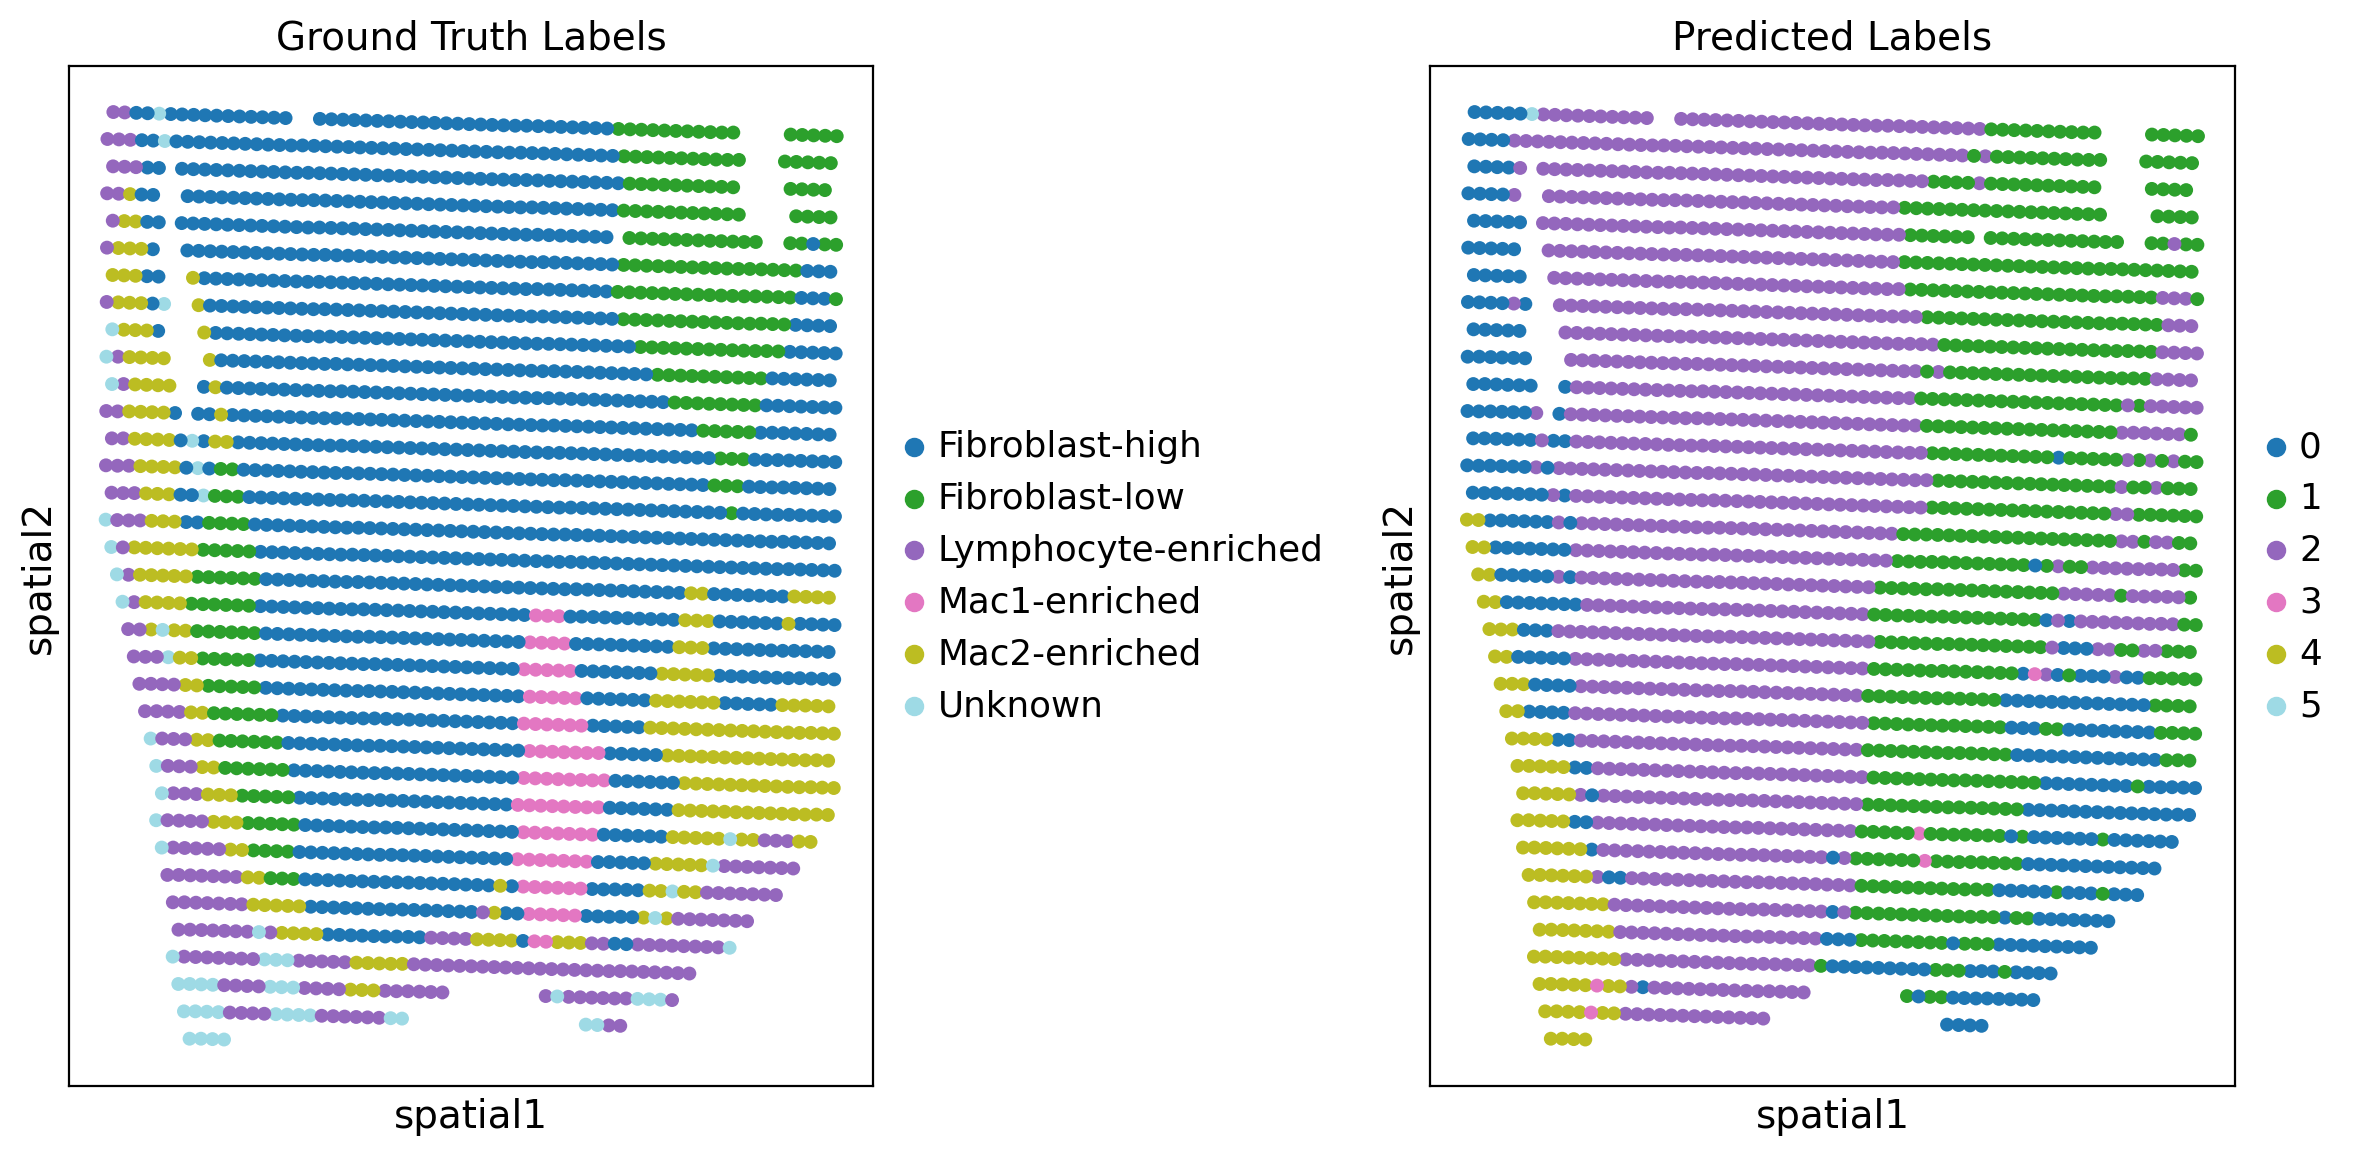

In [22]:
import scanpy as sc
import matplotlib.pyplot as plt


sc.set_figure_params(figsize=(12, 6), dpi=100) 

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sc.pl.embedding(
    adata_omics1,
    basis='spatial',
    color='final_annot',
    title='Ground Truth Labels',
    palette='tab20',
    size=100,
    show=False,
    ax=axes[0]
)

sc.pl.embedding(
    adata_omics1,
    basis='spatial',
    color='pred',
    title='Predicted Labels',
    palette='tab20',
    size=100,
    show=False,
    ax=axes[1]
)
plt.tight_layout()

plt.show()